# _IMPORTS_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nltk, pickle, torch, torch.nn as nn, torchvision.models as models, random, matplotlib.pyplot as plt, numpy as np, os
from collections import Counter
from pycocotools.coco import COCO
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
import torch.utils.data as data

# _BUILDING VOCABULARY_

In [3]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx+=1
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    def __len__(self):
        return len(self.word2idx)

In [4]:
def build_vocab(json, threshold):
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        token = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(token)
        if (i+1)%1000==0:
            print(f'[{i+1}/{len(ids)}] tokenized')
    words = [word for word, cnt in counter.items() if cnt>=threshold]
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    for word in words:
        vocab.add_word(word)
    return vocab

In [5]:
PATH = Path('data')
caption_path = PATH/'annotations/captions_train2014.json'
vocab_path = PATH/'vocab.pkl'

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
vocab = build_vocab(json=caption_path, threshold=4)
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print('Total vocab size:', len(vocab))
print('Saved to path:', vocab_path)

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
[1000/414113] tokenized
[2000/414113] tokenized
[3000/414113] tokenized
[4000/414113] tokenized
[5000/414113] tokenized
[6000/414113] tokenized
[7000/414113] tokenized
[8000/414113] tokenized
[9000/414113] tokenized
[10000/414113] tokenized
[11000/414113] tokenized
[12000/414113] tokenized
[13000/414113] tokenized
[14000/414113] tokenized
[15000/414113] tokenized
[16000/414113] tokenized
[17000/414113] tokenized
[18000/414113] tokenized
[19000/414113] tokenized
[20000/414113] tokenized
[21000/414113] tokenized
[22000/414113] tokenized
[23000/414113] tokenized
[24000/414113] tokenized
[25000/414113] tokenized
[26000/414113] tokenized
[27000/414113] tokenized
[28000/414113] tokenized
[29000/414113] tokenized
[30000/414113] tokenized
[31000/414113] tokenized
[32000/414113] tokenized
[33000/414113] tokenized
[34000/414113] tokenized
[35000/414113] tokenized
[36000/414113] tokenized
[37000/414113] tokenized
[

[318000/414113] tokenized
[319000/414113] tokenized
[320000/414113] tokenized
[321000/414113] tokenized
[322000/414113] tokenized
[323000/414113] tokenized
[324000/414113] tokenized
[325000/414113] tokenized
[326000/414113] tokenized
[327000/414113] tokenized
[328000/414113] tokenized
[329000/414113] tokenized
[330000/414113] tokenized
[331000/414113] tokenized
[332000/414113] tokenized
[333000/414113] tokenized
[334000/414113] tokenized
[335000/414113] tokenized
[336000/414113] tokenized
[337000/414113] tokenized
[338000/414113] tokenized
[339000/414113] tokenized
[340000/414113] tokenized
[341000/414113] tokenized
[342000/414113] tokenized
[343000/414113] tokenized
[344000/414113] tokenized
[345000/414113] tokenized
[346000/414113] tokenized
[347000/414113] tokenized
[348000/414113] tokenized
[349000/414113] tokenized
[350000/414113] tokenized
[351000/414113] tokenized
[352000/414113] tokenized
[353000/414113] tokenized
[354000/414113] tokenized
[355000/414113] tokenized
[356000/4141

# _RESIZING IMAGES_

In [6]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)
def resize_images(image_dir, output_dir, size):
    p = Path(output_dir)
    p.mkdir(parents=True, exist_ok=True)
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(Path(image_dir)/image, 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(Path(output_dir)/image, img.format)
        if (i+1)%1000==0:
            print(f'[{i+1}/{num_images}] resized and saved into {output_dir}')

In [7]:
image_dir = Path('data/train2014')
output_dir = Path('data/resized2014')
image_size = [256, 256]

In [ ]:
resize_images(image_dir, output_dir, image_size)

# _DATALOADER_

In [8]:
class CocoDataset(data.Dataset):
    def __init__(self, root, json, vocab, transform=None):
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform
    def __getitem__(self, index):
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(Path(self.root)/path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target
    def __len__(self):
        return len(self.ids)

In [9]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

In [10]:
def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    coco = CocoDataset(root=root, json=json, vocab=vocab, transform=transform)
    dl = torch.utils.data.DataLoader(dataset=coco, batch_size=batch_size, shuffle=shuffle, 
                                     num_workers=num_workers, collate_fn=collate_fn)
    return dl

# _BUILDING MODEL_

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet34(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_len=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_len = max_seq_len
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        pack = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(pack)
        outputs = self.linear(hiddens[0])
        return outputs
    def sample(self, features, states=None):
        sample_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sample_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sample_ids = torch.stack(sample_ids, 1)
        return sample_ids

# _TRAINING_

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
device

device(type='cuda')

In [14]:
PATH = Path('data')
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
crop_size = 224
caption_path = PATH/'annotations/captions_train2014.json'
vocab_path = PATH/'vocab.pkl'
image_dir = Path('data/resized2014')
log_step = 10
save_step = 1000
embed_size = 256
hidden_size = 512
num_layers = 1
num_epochs = 2
batch_size = 64
num_workers = 2
learning_rate = 0.01

In [15]:
transform = transforms.Compose([
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

In [16]:
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)
train_dl = get_loader(image_dir, caption_path, vocab, transform, batch_size, shuffle=True, num_workers=num_workers)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [17]:
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/nbuser/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 21333168.33it/s]


In [18]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [20]:
total_steps = len(train_dl)
for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_dl):
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%log_step==0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{total_steps}], Loss: {loss.item()}, Perplexity: {np.exp(loss.item())}')
        if i%save_step==0:
            torch.save(decoder.state_dict(), Path(model_path)/'decoder-{}-{}.ckpt'.format(epoch+1, i+1))
            torch.save(encoder.state_dict(), Path(model_path)/'encoder-{}-{}.ckpt'.format(epoch+1, i+1))
            

Epoch [0/2], Step [0/6471], Loss: 9.202795028686523, Perplexity: 9924.83051352364
Epoch [0/2], Step [10/6471], Loss: 4.619014263153076, Perplexity: 101.39403501584951
Epoch [0/2], Step [20/6471], Loss: 3.7529168128967285, Perplexity: 42.6452890967935
Epoch [0/2], Step [30/6471], Loss: 3.882084369659424, Perplexity: 48.52525430099242
Epoch [0/2], Step [40/6471], Loss: 3.6088414192199707, Perplexity: 36.92324945687957
Epoch [0/2], Step [50/6471], Loss: 3.574399471282959, Perplexity: 35.673191605884114
Epoch [0/2], Step [60/6471], Loss: 3.3709959983825684, Perplexity: 29.10750365163898
Epoch [0/2], Step [70/6471], Loss: 3.566725492477417, Perplexity: 35.40048400406289
Epoch [0/2], Step [80/6471], Loss: 3.339759588241577, Perplexity: 28.212343310972773
Epoch [0/2], Step [90/6471], Loss: 3.578594446182251, Perplexity: 35.82315407372507
Epoch [0/2], Step [100/6471], Loss: 3.4880104064941406, Perplexity: 32.720781845874896
Epoch [0/2], Step [110/6471], Loss: 3.4261374473571777, Perplexity: 30

Epoch [0/2], Step [960/6471], Loss: 2.770151138305664, Perplexity: 15.961046152978007
Epoch [0/2], Step [970/6471], Loss: 2.8337302207946777, Perplexity: 17.008789175818436
Epoch [0/2], Step [980/6471], Loss: 2.867903470993042, Perplexity: 17.600080413684974
Epoch [0/2], Step [990/6471], Loss: 2.751582145690918, Perplexity: 15.667400395348277
Epoch [0/2], Step [1000/6471], Loss: 2.930111885070801, Perplexity: 18.7297259561601
Epoch [0/2], Step [1010/6471], Loss: 2.8307945728302, Perplexity: 16.958930577948788
Epoch [0/2], Step [1020/6471], Loss: 2.8838112354278564, Perplexity: 17.88229711394989
Epoch [0/2], Step [1030/6471], Loss: 3.0385801792144775, Perplexity: 20.875582597598697
Epoch [0/2], Step [1040/6471], Loss: 2.8539791107177734, Perplexity: 17.356708881794905
Epoch [0/2], Step [1050/6471], Loss: 2.63753342628479, Perplexity: 13.978681601088601
Epoch [0/2], Step [1060/6471], Loss: 3.107398509979248, Perplexity: 22.362792081749337
Epoch [0/2], Step [1070/6471], Loss: 2.8081896305

Epoch [0/2], Step [1900/6471], Loss: 2.6836767196655273, Perplexity: 14.638817298752969
Epoch [0/2], Step [1910/6471], Loss: 2.608536958694458, Perplexity: 13.579169425938511
Epoch [0/2], Step [1920/6471], Loss: 2.6173489093780518, Perplexity: 13.699357163734591
Epoch [0/2], Step [1930/6471], Loss: 2.5955703258514404, Perplexity: 13.404229960679945
Epoch [0/2], Step [1940/6471], Loss: 2.693239212036133, Perplexity: 14.779472311927828
Epoch [0/2], Step [1950/6471], Loss: 2.691533088684082, Perplexity: 14.75427820732193
Epoch [0/2], Step [1960/6471], Loss: 2.5757126808166504, Perplexity: 13.140678931908138
Epoch [0/2], Step [1970/6471], Loss: 2.7094874382019043, Perplexity: 15.02157405629876
Epoch [0/2], Step [1980/6471], Loss: 2.5478763580322266, Perplexity: 12.77993493824428
Epoch [0/2], Step [1990/6471], Loss: 2.5472772121429443, Perplexity: 12.772280186146352
Epoch [0/2], Step [2000/6471], Loss: 2.877197027206421, Perplexity: 17.76441017152627
Epoch [0/2], Step [2010/6471], Loss: 2.5

Epoch [0/2], Step [2840/6471], Loss: 2.4848082065582275, Perplexity: 11.998818739387236
Epoch [0/2], Step [2850/6471], Loss: 2.675255537033081, Perplexity: 14.516058756274559
Epoch [0/2], Step [2860/6471], Loss: 2.7481496334075928, Perplexity: 15.613714043286588
Epoch [0/2], Step [2870/6471], Loss: 2.5492355823516846, Perplexity: 12.797317547369778
Epoch [0/2], Step [2880/6471], Loss: 2.488645315170288, Perplexity: 12.044947954913537
Epoch [0/2], Step [2890/6471], Loss: 2.57560658454895, Perplexity: 13.139284828874288
Epoch [0/2], Step [2900/6471], Loss: 2.464076042175293, Perplexity: 11.752618210285089
Epoch [0/2], Step [2910/6471], Loss: 2.4074807167053223, Perplexity: 11.105946845544082
Epoch [0/2], Step [2920/6471], Loss: 2.7205424308776855, Perplexity: 15.188558754139276
Epoch [0/2], Step [2930/6471], Loss: 2.638455867767334, Perplexity: 13.991582065915921
Epoch [0/2], Step [2940/6471], Loss: 2.382880449295044, Perplexity: 10.836070705912988
Epoch [0/2], Step [2950/6471], Loss: 2.

Epoch [0/2], Step [3790/6471], Loss: 2.6977570056915283, Perplexity: 14.8463939734726
Epoch [0/2], Step [3800/6471], Loss: 2.622192621231079, Perplexity: 13.765873866228912
Epoch [0/2], Step [3810/6471], Loss: 2.663987159729004, Perplexity: 14.353404475245043
Epoch [0/2], Step [3820/6471], Loss: 2.597921371459961, Perplexity: 13.435780991087372
Epoch [0/2], Step [3830/6471], Loss: 2.525312662124634, Perplexity: 12.49480130406214
Epoch [0/2], Step [3840/6471], Loss: 2.706583023071289, Perplexity: 14.978008466228728
Epoch [0/2], Step [3850/6471], Loss: 2.627091884613037, Perplexity: 13.833481987747557
Epoch [0/2], Step [3860/6471], Loss: 2.5890097618103027, Perplexity: 13.316578487535898
Epoch [0/2], Step [3870/6471], Loss: 2.5942487716674805, Perplexity: 13.386527244618376
Epoch [0/2], Step [3880/6471], Loss: 2.4338183403015137, Perplexity: 11.40233706739571
Epoch [0/2], Step [3890/6471], Loss: 2.649219512939453, Perplexity: 14.142995911274712
Epoch [0/2], Step [3900/6471], Loss: 2.5325

Epoch [0/2], Step [4730/6471], Loss: 2.4491360187530518, Perplexity: 11.578338928868979
Epoch [0/2], Step [4740/6471], Loss: 2.4735474586486816, Perplexity: 11.864460970593207
Epoch [0/2], Step [4750/6471], Loss: 2.3258981704711914, Perplexity: 10.235869514081179
Epoch [0/2], Step [4760/6471], Loss: 2.452806234359741, Perplexity: 11.620912007504087
Epoch [0/2], Step [4770/6471], Loss: 2.5326502323150635, Perplexity: 12.586819969498181
Epoch [0/2], Step [4780/6471], Loss: 2.3767917156219482, Perplexity: 10.770293211357064
Epoch [0/2], Step [4790/6471], Loss: 2.547210454940796, Perplexity: 12.771427572915423
Epoch [0/2], Step [4800/6471], Loss: 2.77122163772583, Perplexity: 15.978141592326399
Epoch [0/2], Step [4810/6471], Loss: 2.4274284839630127, Perplexity: 11.329710056808693
Epoch [0/2], Step [4820/6471], Loss: 2.5734360218048096, Perplexity: 13.110796116194273
Epoch [0/2], Step [4830/6471], Loss: 2.6094133853912354, Perplexity: 13.591075789308695
Epoch [0/2], Step [4840/6471], Loss:

Epoch [0/2], Step [5670/6471], Loss: 2.596625804901123, Perplexity: 13.418385313605667
Epoch [0/2], Step [5680/6471], Loss: 2.3779168128967285, Perplexity: 10.78241765820983
Epoch [0/2], Step [5690/6471], Loss: 2.4787256717681885, Perplexity: 11.92605701914462
Epoch [0/2], Step [5700/6471], Loss: 2.32136869430542, Perplexity: 10.189611229067737
Epoch [0/2], Step [5710/6471], Loss: 2.4839794635772705, Perplexity: 11.988878921923071
Epoch [0/2], Step [5720/6471], Loss: 2.5944535732269287, Perplexity: 13.389269107032936
Epoch [0/2], Step [5730/6471], Loss: 2.577854871749878, Perplexity: 13.168858947883422
Epoch [0/2], Step [5740/6471], Loss: 2.4439587593078613, Perplexity: 11.518549769833113
Epoch [0/2], Step [5750/6471], Loss: 2.650414228439331, Perplexity: 14.159902865193569
Epoch [0/2], Step [5760/6471], Loss: 2.3408143520355225, Perplexity: 10.389693987050908
Epoch [0/2], Step [5770/6471], Loss: 2.465001106262207, Perplexity: 11.763495165483294
Epoch [0/2], Step [5780/6471], Loss: 2.7

Epoch [1/2], Step [140/6471], Loss: 2.357708215713501, Perplexity: 10.566707068376742
Epoch [1/2], Step [150/6471], Loss: 2.3983514308929443, Perplexity: 11.005018883655486
Epoch [1/2], Step [160/6471], Loss: 2.179311752319336, Perplexity: 8.840219903656003
Epoch [1/2], Step [170/6471], Loss: 2.413102388381958, Perplexity: 11.168556653370505
Epoch [1/2], Step [180/6471], Loss: 2.441499710083008, Perplexity: 11.4902598863138
Epoch [1/2], Step [190/6471], Loss: 2.3756768703460693, Perplexity: 10.758292691454946
Epoch [1/2], Step [200/6471], Loss: 2.4040467739105225, Perplexity: 11.067875064964445
Epoch [1/2], Step [210/6471], Loss: 2.460035800933838, Perplexity: 11.705230590665542
Epoch [1/2], Step [220/6471], Loss: 2.532907485961914, Perplexity: 12.590058391367645
Epoch [1/2], Step [230/6471], Loss: 2.4938063621520996, Perplexity: 12.107273190593775
Epoch [1/2], Step [240/6471], Loss: 2.4699301719665527, Perplexity: 11.82162134225436
Epoch [1/2], Step [250/6471], Loss: 2.413976669311523

Epoch [1/2], Step [1090/6471], Loss: 2.473675489425659, Perplexity: 11.865980083994252
Epoch [1/2], Step [1100/6471], Loss: 2.311344623565674, Perplexity: 10.087980075241699
Epoch [1/2], Step [1110/6471], Loss: 2.4508495330810547, Perplexity: 11.598195585992833
Epoch [1/2], Step [1120/6471], Loss: 2.5162265300750732, Perplexity: 12.38178610252555
Epoch [1/2], Step [1130/6471], Loss: 2.4197049140930176, Perplexity: 11.242541309858455
Epoch [1/2], Step [1140/6471], Loss: 2.4663116931915283, Perplexity: 11.77892235561899
Epoch [1/2], Step [1150/6471], Loss: 2.4822635650634766, Perplexity: 11.968324861782635
Epoch [1/2], Step [1160/6471], Loss: 2.4289958477020264, Perplexity: 11.34748175724649
Epoch [1/2], Step [1170/6471], Loss: 2.4950928688049316, Perplexity: 12.122859301769275
Epoch [1/2], Step [1180/6471], Loss: 2.2743120193481445, Perplexity: 9.721228694165118
Epoch [1/2], Step [1190/6471], Loss: 2.4189229011535645, Perplexity: 11.233752933841563
Epoch [1/2], Step [1200/6471], Loss: 2

Epoch [1/2], Step [2030/6471], Loss: 2.367116689682007, Perplexity: 10.666592806126548
Epoch [1/2], Step [2040/6471], Loss: 2.5054614543914795, Perplexity: 12.249210113626345
Epoch [1/2], Step [2050/6471], Loss: 2.419834613800049, Perplexity: 11.243999558737812
Epoch [1/2], Step [2060/6471], Loss: 2.336054563522339, Perplexity: 10.340358746754081
Epoch [1/2], Step [2070/6471], Loss: 2.4982945919036865, Perplexity: 12.161735542687852
Epoch [1/2], Step [2080/6471], Loss: 2.5426700115203857, Perplexity: 12.713571075095789
Epoch [1/2], Step [2090/6471], Loss: 2.6876590251922607, Perplexity: 14.697229772749896
Epoch [1/2], Step [2100/6471], Loss: 2.37770414352417, Perplexity: 10.780124812029515
Epoch [1/2], Step [2110/6471], Loss: 2.3873307704925537, Perplexity: 10.884402166566687
Epoch [1/2], Step [2120/6471], Loss: 2.5068812370300293, Perplexity: 12.266613681199681
Epoch [1/2], Step [2130/6471], Loss: 2.29667592048645, Perplexity: 9.941082523132813
Epoch [1/2], Step [2140/6471], Loss: 2.4

Epoch [1/2], Step [2980/6471], Loss: 2.4549753665924072, Perplexity: 11.646146661068384
Epoch [1/2], Step [2990/6471], Loss: 2.4365756511688232, Perplexity: 11.433820239804486
Epoch [1/2], Step [3000/6471], Loss: 2.4694833755493164, Perplexity: 11.816340663974632
Epoch [1/2], Step [3010/6471], Loss: 2.5157172679901123, Perplexity: 12.37548213364185
Epoch [1/2], Step [3020/6471], Loss: 2.1229257583618164, Perplexity: 8.355548075182968
Epoch [1/2], Step [3030/6471], Loss: 2.3733627796173096, Perplexity: 10.733425809287981
Epoch [1/2], Step [3040/6471], Loss: 2.3186697959899902, Perplexity: 10.16214758195274
Epoch [1/2], Step [3050/6471], Loss: 2.549844980239868, Perplexity: 12.80511858238327
Epoch [1/2], Step [3060/6471], Loss: 2.376221179962158, Perplexity: 10.764150127604397
Epoch [1/2], Step [3070/6471], Loss: 2.504237413406372, Perplexity: 12.23422575101995
Epoch [1/2], Step [3080/6471], Loss: 2.5282297134399414, Perplexity: 12.531302492677838
Epoch [1/2], Step [3090/6471], Loss: 2.2

Epoch [1/2], Step [3920/6471], Loss: 2.4259114265441895, Perplexity: 11.312535266978987
Epoch [1/2], Step [3930/6471], Loss: 2.5694265365600586, Perplexity: 13.058333816309952
Epoch [1/2], Step [3940/6471], Loss: 2.470414400100708, Perplexity: 11.827347090071822
Epoch [1/2], Step [3950/6471], Loss: 2.6612515449523926, Perplexity: 14.314192748411253
Epoch [1/2], Step [3960/6471], Loss: 2.2229177951812744, Perplexity: 9.2342352031003
Epoch [1/2], Step [3970/6471], Loss: 2.5441806316375732, Perplexity: 12.732790964644083
Epoch [1/2], Step [3980/6471], Loss: 2.3020026683807373, Perplexity: 9.994177449629833
Epoch [1/2], Step [3990/6471], Loss: 2.3649649620056152, Perplexity: 10.64366587827125
Epoch [1/2], Step [4000/6471], Loss: 2.216205596923828, Perplexity: 9.172460738816978
Epoch [1/2], Step [4010/6471], Loss: 2.474095582962036, Perplexity: 11.870965952722603
Epoch [1/2], Step [4020/6471], Loss: 2.4172472953796387, Perplexity: 11.214945354007877
Epoch [1/2], Step [4030/6471], Loss: 2.36

Epoch [1/2], Step [4860/6471], Loss: 2.3935418128967285, Perplexity: 10.952216029351254
Epoch [1/2], Step [4870/6471], Loss: 2.296412467956543, Perplexity: 9.938463864753311
Epoch [1/2], Step [4880/6471], Loss: 2.570157289505005, Perplexity: 13.067879719626001
Epoch [1/2], Step [4890/6471], Loss: 2.3040947914123535, Perplexity: 10.015108385866629
Epoch [1/2], Step [4900/6471], Loss: 2.47408127784729, Perplexity: 11.870796138407112
Epoch [1/2], Step [4910/6471], Loss: 2.4311745166778564, Perplexity: 11.372231114243327
Epoch [1/2], Step [4920/6471], Loss: 2.168734550476074, Perplexity: 8.747207884007784
Epoch [1/2], Step [4930/6471], Loss: 2.406252145767212, Perplexity: 11.092310780161442
Epoch [1/2], Step [4940/6471], Loss: 2.5207996368408203, Perplexity: 12.438539001949684
Epoch [1/2], Step [4950/6471], Loss: 2.42244291305542, Perplexity: 11.273365555419279
Epoch [1/2], Step [4960/6471], Loss: 2.4974606037139893, Perplexity: 12.151597027167774
Epoch [1/2], Step [4970/6471], Loss: 2.674

Epoch [1/2], Step [5810/6471], Loss: 2.4555938243865967, Perplexity: 11.653351538969993
Epoch [1/2], Step [5820/6471], Loss: 2.466444253921509, Perplexity: 11.780483881661063
Epoch [1/2], Step [5830/6471], Loss: 2.221261739730835, Perplexity: 9.218955453110276
Epoch [1/2], Step [5840/6471], Loss: 2.2586309909820557, Perplexity: 9.569978807423
Epoch [1/2], Step [5850/6471], Loss: 2.468747138977051, Perplexity: 11.807644243531673
Epoch [1/2], Step [5860/6471], Loss: 2.4750547409057617, Perplexity: 11.882357546311255
Epoch [1/2], Step [5870/6471], Loss: 2.3478755950927734, Perplexity: 10.463317773395366
Epoch [1/2], Step [5880/6471], Loss: 2.3165650367736816, Perplexity: 10.140781201602893
Epoch [1/2], Step [5890/6471], Loss: 2.432603359222412, Perplexity: 11.388491856139309
Epoch [1/2], Step [5900/6471], Loss: 2.4378817081451416, Perplexity: 11.448763216560048
Epoch [1/2], Step [5910/6471], Loss: 2.5630719661712646, Perplexity: 12.975616808783618
Epoch [1/2], Step [5920/6471], Loss: 2.37

# _Evaluation_

In [21]:
torch.save(decoder.state_dict(), Path(model_path)/'decoder-2-6741.ckpt')
torch.save(encoder.state_dict(), Path(model_path)/'encoder-2-6741.ckpt')

In [111]:
encoder_path = Path('models/encoder-2-6741.ckpt')
decoder_path = Path('models/decoder-2-6741.ckpt')

In [112]:
image_test_path = Path(PATH)/'val2014'
image_test_list = [image for image in Path(image_test_path).iterdir()]
image_to_test = random.choice(image_test_list)

In [113]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

In [114]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

In [115]:
encoder = EncoderCNN(embed_size).eval()
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [116]:
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

In [117]:
image = load_image(image_to_test, test_transform)
image_tensor = image.to(device)

In [118]:
feature = encoder(image_tensor)
sample_ids = decoder.sample(feature)
sample_ids = sample_ids[0].cpu().numpy()

In [119]:
sample_caption = []
for word_id in sample_ids:
    word = vocab.idx2word[word_id]
    sample_caption.append(word)
    if word=='<end>':
        break
sentence = ' '.join(sample_caption)

<start> a small child is holding a teddy bear . <end>


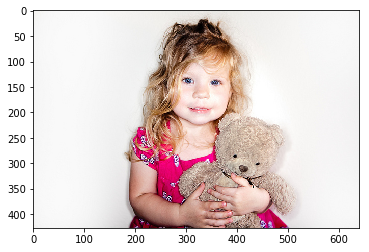

In [120]:
print(sentence)
image = Image.open(image_to_test)
plt.imshow(np.asarray(image))